## SALARY PREDICTION

We have a dataset about tech job positions and salaries from glassdoor.com. We are interested at this 3 points:

- Identify which factors most affect data science salaries
- Determine which states and cities offer the highest paying data science jobs
- Predict what a data science job posting will pay based on the job description


### EDA

In [1]:
# import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

In [2]:
# reading the dataset

data = pd.read_csv('datasets/glassdoor_jobs.csv', index_col=0 )
pd.set_option('display.max_columns', None)
data.head()

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,Competitors
0,Data Scientist,$53K-$91K (Glassdoor est.),"Data Scientist\nLocation: Albuquerque, NM\nEdu...",3.8,Tecolote Research\n3.8,"Albuquerque, NM","Goleta, CA",501 to 1000 employees,1973,Company - Private,Aerospace & Defense,Aerospace & Defense,$50 to $100 million (USD),-1
1,Healthcare Data Scientist,$63K-$112K (Glassdoor est.),What You Will Do:\n\nI. General Summary\n\nThe...,3.4,University of Maryland Medical System\n3.4,"Linthicum, MD","Baltimore, MD",10000+ employees,1984,Other Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),-1
2,Data Scientist,$80K-$90K (Glassdoor est.),"KnowBe4, Inc. is a high growth information sec...",4.8,KnowBe4\n4.8,"Clearwater, FL","Clearwater, FL",501 to 1000 employees,2010,Company - Private,Security Services,Business Services,$100 to $500 million (USD),-1
3,Data Scientist,$56K-$97K (Glassdoor est.),*Organization and Job ID**\nJob ID: 310709\n\n...,3.8,PNNL\n3.8,"Richland, WA","Richland, WA",1001 to 5000 employees,1965,Government,Energy,"Oil, Gas, Energy & Utilities",$500 million to $1 billion (USD),"Oak Ridge National Laboratory, National Renewa..."
4,Data Scientist,$86K-$143K (Glassdoor est.),Data Scientist\nAffinity Solutions / Marketing...,2.9,Affinity Solutions\n2.9,"New York, NY","New York, NY",51 to 200 employees,1998,Company - Private,Advertising & Marketing,Business Services,Unknown / Non-Applicable,"Commerce Signals, Cardlytics, Yodlee"


In [3]:
# checking null values whitin the features

for column in data.columns:
    if data[column].isnull().sum() > 0:
        print(f"Column {column} has {data[column].isnull().sum()} null values")

In [4]:
# let's create a list with the categorical variables to plot them

categorical_features = data.select_dtypes('object').columns.to_list()
categorical_features.remove('Job Description') # we don't want to plot this, because every instance is so long
print(f"We have {len(categorical_features)} categorical features")

We have 11 categorical features


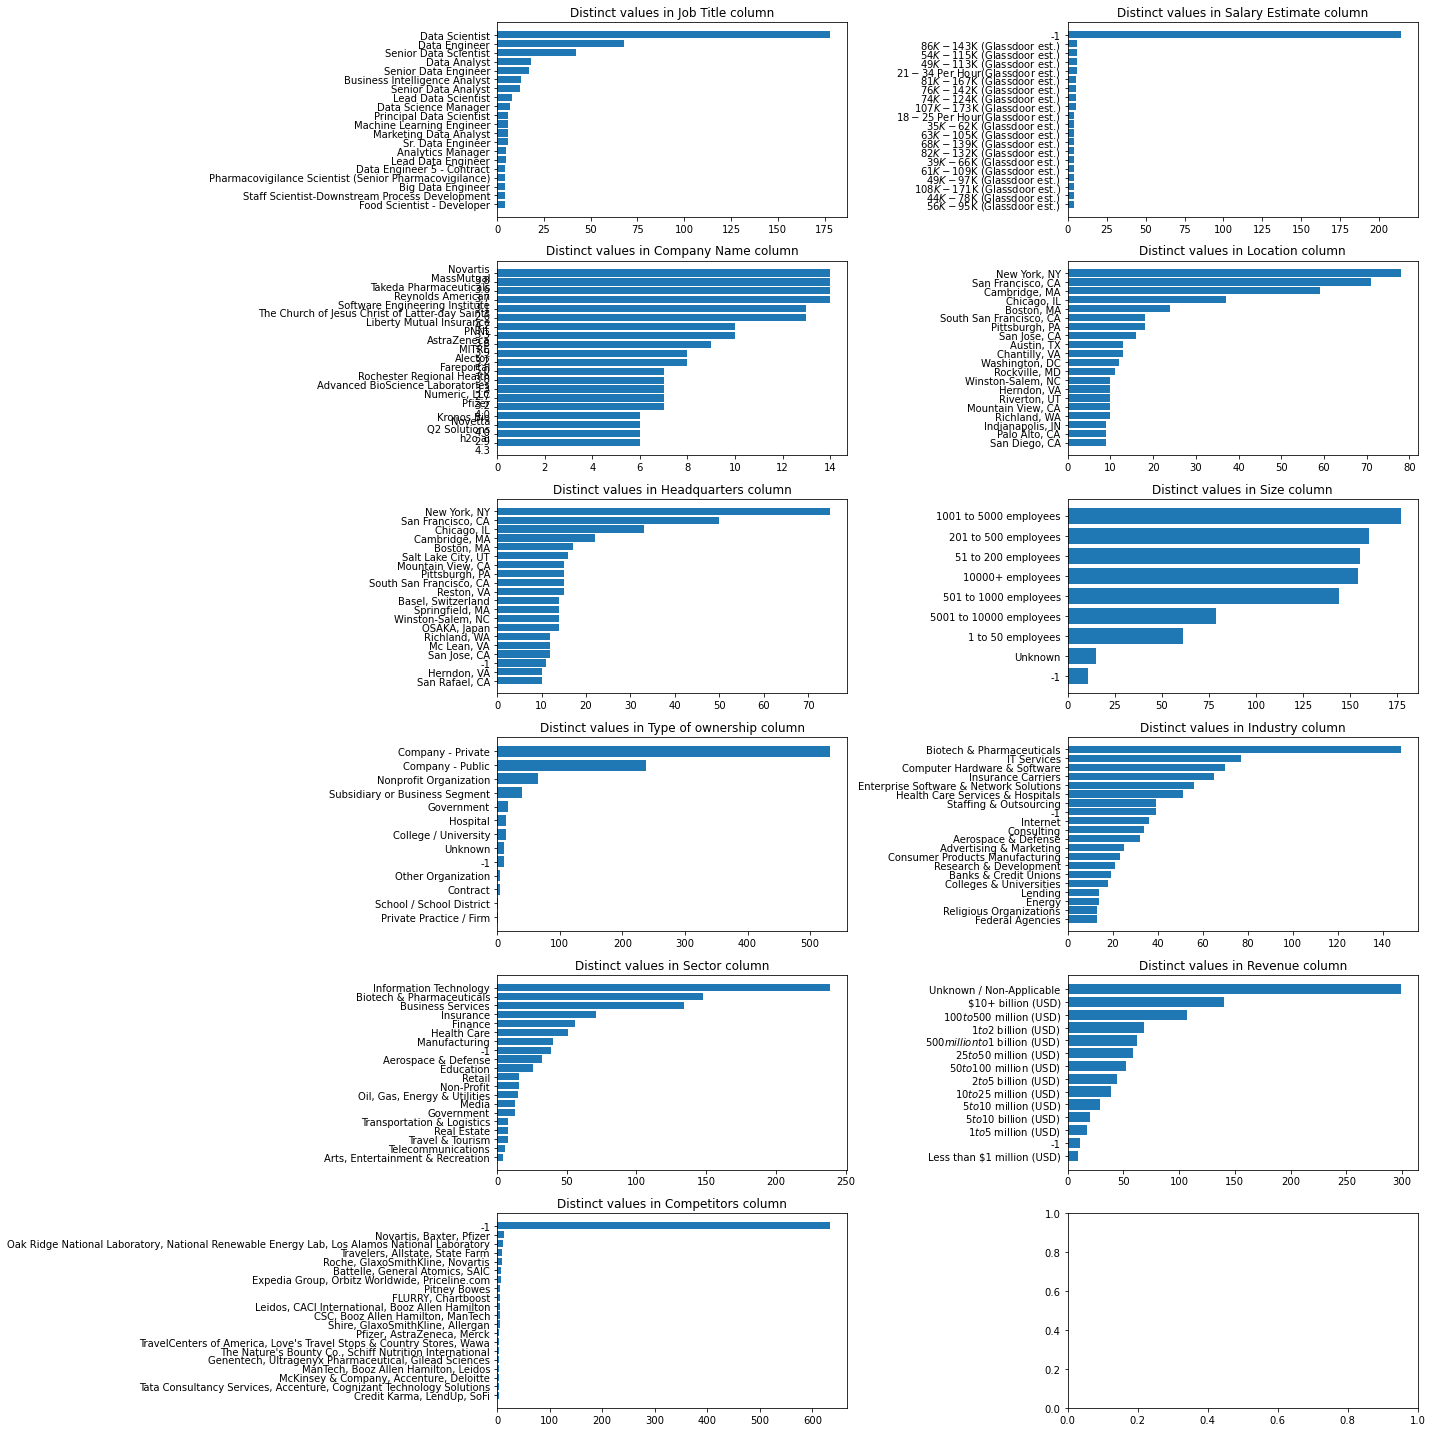

In [5]:
# let's plot the first 20 higher values from every categorical variable

rows = 6
cols = 2
fig, ax = plt.subplots(nrows = rows, ncols = cols, figsize = (20,20))
feature = 0
for row in range(rows):
    for col in range(cols):
        ax[row, col].set_title('Distinct values in '+categorical_features[feature] + ' column')
        ax[row,col].barh(data[categorical_features[feature]].value_counts().index.to_list()[:20], data[categorical_features[feature]].value_counts().values[:20])
        ax[row,col].invert_yaxis()
        feature +=1
        if feature == len(categorical_features):
            break
    plt.tight_layout()
plt.show()

From the previous visualization, we can see some assumptions such as:
1. There are multiple positions that could be simplified e.g: (Data Scientist, Sr. Data Scientist)
2. The salary column has 2 different ways to show the values, per year and per hour
3. The competitors column has the values separated by commas
4. From the location column we can extract the state, and this one is separated by commas
5. There are some columns that have multiple values and could be handled into less classes (industry, ownership, size etc...)
6. The dataset has null values as -1, for thar reason we don't see null values with isnull() pandas function

1. Dealing with job positions

In [6]:
def job_cleaning(x):
    if 'data scientist' in x.lower():
        return 'data scientist'
    elif 'data engineer' in x.lower():
        return 'data engineer'
    elif 'analyst' in x.lower():
        return 'data analyst'
    elif 'machine learning' in x.lower() or 'machine learning engineer' in x.lower() or 'deep learning' in x.lower():
        return 'mle'
    elif 'manager' in x.lower():
        return 'manager'
    elif 'director' in x.lower() or 'vp' in x.lower():
        return 'director'
    else:
        return 'na' # not a data science position

df = data.copy()
df['job_simpl'] = df['Job Title'].apply(lambda x: job_cleaning(x))
df.groupby('job_simpl').size()

# let's create a list of the columns that we can drop after transformations and cleaning, to drop them later

to_drop = ['Job Title']

In [7]:
# let's see if we have some information about seniority in the dataset

senior_positions = df[df['Job Description'].str.contains(case = False, pat = 'sr') | df['Job Title'].str.contains(case = False, pat = 'sr') | 
                    df['Job Description'].str.contains(case = False, pat = 'senior') | df['Job Title'].str.contains(case = False, pat = 'senior')].shape[0]

print(f"There are {senior_positions} senior positions")

There are 362 senior positions


In [8]:
def seniority(x):
    if 'sr' in x['Job Description'].lower() or 'sr' in x['Job Title'].lower():
        return 1
    elif 'senior' in x['Job Description'].lower() or 'senior' in x['Job Title'].lower():
        return 1
    else:
        return 0

df['seniority'] = df.apply(seniority, axis = 1)
print(f"There are {df[df.seniority == 1]['seniority'].sum()} senior positions within the new column")

There are 362 senior positions within the new column


2. Dealing with salaries

In [9]:
def min_salary(x):
    if x.split("(")[0].replace('$','').replace('K','').rstrip().split('-')[0].isnumeric(): # for inputs like $53K-$91K (Glassdoor est.)
        return x.split(" (")[0].replace('$','').replace('K','').rstrip().split('-')[0]
    elif ':' in x and x.split(':')[1].replace('$','').replace('K','').split('-')[0].isnumeric(): # for inputs like 'Employer Provided Salary:$150K-$160K'
        return x.split(':')[1].replace('$','').replace('K','').split('-')[0]
    else:
        return x

def max_salary(x):
    if x.split("(")[0].replace('$','').replace('K','').replace('Per Hour', '').rstrip().split('-')[1].isnumeric(): # for inputs like $53K-$91K (Glassdoor est.)
        return x.split("(")[0].replace('$','').replace('K','').replace('Per Hour', '').rstrip().split('-')[1]
    elif ':' in x and x.split(':')[1].replace('$','').replace('K','').replace('Per Hour', '').split('-')[1].isnumeric(): # for inputs like 'Employer Provided Salary:$150K-$160K'
        return x.split(':')[1].replace('$','').replace('K','').replace('Per Hour', '').split('-')[1]
    else:
        return x

In [10]:
df['min_salary'] = df['Salary Estimate'].apply(lambda x: min_salary(x)).astype('int64')
df['max_salary'] = df['Salary Estimate'].apply(lambda x: max_salary(x)).astype('int64')

As we have some salaries per hour, we need to convert them into anually salaries

In [11]:
# 48 hours per week, 4 weeks in a month, and 12 months in a year

df['min_salary'] = df.apply(lambda x: int((x['min_salary']*48*4*12)/1000) if 'per hour' in x['Salary Estimate'].lower() else x['min_salary'], axis = 1)
df['max_salary'] = df.apply(lambda x: int((x['max_salary']*48*4*12)/1000) if 'per hour' in x['Salary Estimate'].lower() else x['max_salary'], axis = 1)  
df['avg_salary'] = (df['min_salary'] + df['min_salary'])/2

to_drop.append('Salary Estimate')

3. Dealing with competitors

In [12]:
df['num_competitors'] =  df['Competitors'].apply(lambda x: 0 if x == '-1' else len(x.split(',')))
to_drop.append('Competitors')

4. Dealing with states

In [13]:
df['job_state'] = df['Location'].apply(lambda x: x.split(',')[1].strip() if len(x.split(',')) == 2 else x.split(',')[0].strip())
df['job_state'].unique()

array(['NM', 'MD', 'FL', 'WA', 'NY', 'TX', 'CA', 'VA', 'MA', 'NJ', 'CO',
       'IL', 'KY', 'Oregon', 'OR', 'CT', 'MI', 'AZ', 'DC', 'OH', 'AL',
       'MO', 'RI', 'PA', 'GA', 'New Jersey', 'IN', 'LA', 'WI', 'Virginia',
       'NC', 'MN', 'NE', 'Santa Fe Springs', 'UT', 'TN', 'DE', 'ID', 'AK',
       'United States', 'IA', 'SC', 'KS', 'PR', 'Maryland', 'Michigan'],
      dtype=object)

In [14]:
# let's clean the job_state variable

def state_cleaning(x):
    if 'new jersey' in x.lower():
        return 'NJ'
    elif 'oregon' in x.lower():
        return 'OR'
    elif 'virginia' in x.lower():
        return 'VA'
    elif 'santa fe springs' in x.lower():
        return 'CA'
    elif 'maryland' in x.lower():
        return 'MD'
    elif 'michigan' in x.lower():
        return 'MI'
    elif 'united states' in x.lower():
        return 'DC' # just for clean that register
    else:
        return x

to_drop.extend(['Location', 'Headquarters']) # update columns to drop

df['job_state'] = df['job_state'].apply(lambda x: state_cleaning(x))
df['job_state'].unique()

array(['NM', 'MD', 'FL', 'WA', 'NY', 'TX', 'CA', 'VA', 'MA', 'NJ', 'CO',
       'IL', 'KY', 'OR', 'CT', 'MI', 'AZ', 'DC', 'OH', 'AL', 'MO', 'RI',
       'PA', 'GA', 'IN', 'LA', 'WI', 'NC', 'MN', 'NE', 'UT', 'TN', 'DE',
       'ID', 'AK', 'IA', 'SC', 'KS', 'PR'], dtype=object)

5. Dealing with other variables

In [15]:
# cleaning industry column

def industry_cleaning(x):
    if 'internet' in x.lower() or 'it services' in x.lower() or 'software' in x.lower() or 'telecommunications' in x.lower() or 'computer' in x.lower() or 'video games' in x.lower():
        return 'tech'
    elif 'bank' in x.lower() or 'financ' in x.lower() or 'insurance' in x.lower() or 'stock' in x.lower() or 'brokerage' in x.lower() or 'accounting' in x.lower() or 'lending' in x.lower() or 'auctions' in x.lower() or 'real estate' in x.lower():
        return 'finance'
    if 'health' in x.lower() or 'beauty' in x.lower() or 'pharma' in x.lower() or 'care' in x.lower():
        return 'health'
    if 'retail' in x.lower() or 'clothing' in x.lower() or 'logistics' in x.lower() or 'wholesale' in x.lower() or 'production' in x.lower() or 'store' in x.lower() or 'transportation' in x.lower() or 'trucking' in x.lower():
        return 'logistics'
    elif 'manufacturing' in x.lower() or 'mining' in x.lower() or 'construction' in x.lower() or 'energy' in x.lower() or 'metals brokers' in x.lower():
        return 'production'
    if 'social' in x.lower() or 'religious' in x.lower() or 'education' in x.lower() or 'college' in x.lower() or 'utilities' in x.lower():
        return 'social'
    elif 'gambling' in x.lower() or 'travel' in x.lower() or 'tv broadcast' in x.lower():
        return 'hobbies'
    elif 'consulting' in x.lower() or 'publishing' in x.lower() or 'rental' in x.lower() or 'service' in x.lower() or 'outsourcing' in x.lower() or 'agencies' in x.lower():
        return 'services'
    else:
        return 'other'

to_drop.extend(['Industry', 'Sector'])

df['industry'] = df['Industry'].apply(lambda x: industry_cleaning(x))
df['industry'].unique()

array(['other', 'health', 'services', 'production', 'finance', 'tech',
       'logistics', 'social', 'hobbies'], dtype=object)

In [16]:
# cleaning ownership column

def ownership_clean(x):
    if 'private' in x.lower():
        return 'private'
    elif 'public' in x.lower() or 'government' in x.lower():
        return 'public'
    elif '-1' in x.lower() or 'unknown' in x.lower() or 'other' in x.lower():
        return 'other'
    elif 'school' in x.lower() or 'university' in x.lower():
        return 'education'
    else:
        return x.lower()

to_drop.append('Type of ownership')

df['ownership'] = df['Type of ownership'].apply(lambda x: ownership_clean(x))
df['ownership'].unique() 

array(['private', 'other', 'public', 'hospital',
       'subsidiary or business segment', 'nonprofit organization',
       'contract', 'education'], dtype=object)

In [17]:
# cleaning revenue column

def revenue_cleaning(x):
    if 'less than $1 million' in x.lower() or '$1 to $5 million' in x.lower() or '$5 to $10 million' in x.lower() or '$10 to $25 million' in x.lower() or '$25 to $50 million' in x.lower() or '$50 to $100 million' in x.lower():
        return '$0 to $100 million'
    elif '$100 to $500 million' in x.lower():
        return '$100 to $500 million'
    elif '$500 million to $1 billion' in x.lower():
        return '$500 million to $1 billion'
    elif '$1 to $2 billion' in x.lower() or '$2 to $5 billion' in x.lower() or '$5 to $10 billion' in x.lower():
        return '$1 to $10 billion'
    elif '$10+ billion' in x.lower():
        return '$10+ billion'
    elif 'unknown' in x.lower() or '-1' in x.lower():
        return 'unknown'
    else:
        return x.lower()

to_drop.append('Revenue')
df['revenue'] = df['Revenue'].apply(lambda x: revenue_cleaning(x))

In [18]:
# checking if we did it correctly
df[['revenue', 'Revenue']].value_counts().sort_index()

revenue                     Revenue                         
$0 to $100 million          $1 to $5 million (USD)               17
                            $10 to $25 million (USD)             39
                            $25 to $50 million (USD)             59
                            $5 to $10 million (USD)              29
                            $50 to $100 million (USD)            52
                            Less than $1 million (USD)            9
$1 to $10 billion           $1 to $2 billion (USD)               68
                            $2 to $5 billion (USD)               44
                            $5 to $10 billion (USD)              20
$10+ billion                $10+ billion (USD)                  140
$100 to $500 million        $100 to $500 million (USD)          107
$500 million to $1 billion  $500 million to $1 billion (USD)     62
unknown                     -1                                   11
                            Unknown / Non-Applicable   

In [19]:
# cleaning size column

def size_cleaning(x):
    if '1 to 50 employees' in x.lower() or '51 to 200 employees' in x.lower() or '201 to 500 employees' in x.lower() or '501 to 1000 employees' in x.lower():
        return '1 to 1000 employees'
    elif '1001 to 5000 employees' in x.lower():
        return '1001 to 5000 employees'
    elif '5001 to 10000 employees' in x.lower() or '10000+ employees' in x.lower():
        return '5000+ employees'
    elif 'unknown' in x.lower() or '-1' in x.lower():
        return 'unknown'
    else:
        return x

to_drop.append('Size')
df['size'] = df['Size'].apply(lambda x: size_cleaning(x))

In [20]:
# let's calculate the age of the companies

df['company_age'] = df['Founded'].apply(lambda x: x if x < 1 else 2023 - x)
to_drop.append('Founded')

In [21]:
# finding skills in the job description

df['python'] = df['Job Description'].apply(lambda x: 1 if 'python' in x.lower() else 0)
df['cloud'] = df['Job Description'].apply(lambda x: 1 if 'aws' in x.lower() or 'azure' in x.lower() or 'cloud' in x.lower() else 0)
df['spark'] = df['Job Description'].apply(lambda x: 1 if 'spark' in x.lower() else 0)
df['excel'] = df['Job Description'].apply(lambda x: 1 if 'excel' in x.lower() else 0)

to_drop.extend(['Job Description', 'Company Name'])

In [22]:
# now we select the job positions that we want to analyze, only the ones related with data science and drop the columns we don't need anymore

dx = df[df.job_simpl != 'na'].copy().reset_index(drop = True).drop(columns = to_drop)
dx.drop(columns = ['min_salary', 'max_salary'], inplace=True) # we want to predict the avg salary

#### Analizing continuous variables

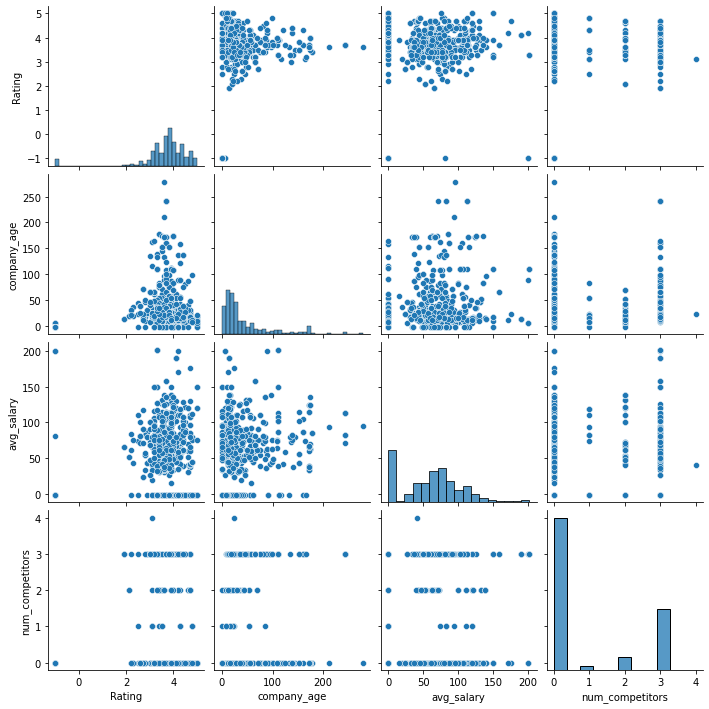

In [23]:
continuous_variables = ['Rating', 'company_age', 'avg_salary' , 'num_competitors']
sns.pairplot(dx[continuous_variables])
plt.show()

We can see for rating some negative values, also negative values in company age, and some values as "1" for min, max and avg salary. We can treat them as null values and replace them or drop them

In [24]:
dx.replace(to_replace = -1, value = np.nan, inplace=True)
dx.avg_salary.replace(to_replace = 0, value = np.nan) # should not be salaries in 0

0      53.0
1      63.0
2      80.0
3      56.0
4      86.0
       ... 
717    37.0
718    62.0
719    72.0
720    95.0
721     NaN
Name: avg_salary, Length: 722, dtype: float64

In [25]:
def impute_with_mean(df, column):
    mean = round(df[column].mean(), 1)
    df[column] = np.where(np.isnan(df[column]), mean, df[column])

impute_with_mean(dx, 'Rating')
impute_with_mean(dx, 'company_age')
impute_with_mean(dx, 'avg_salary')